In [82]:
import keras_ocr
import pytesseract

from google.cloud import vision
import io
    
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import keras_ocr
import time

import glob
import numpy as np

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# 이미지데이터 준비

- project 폴더 안에 있는 20개 이미지 파일명들을 가져옴

In [2]:
image_path = os.getenv('HOME') + '/aiffel/ocr_python/project'

In [75]:
keywords = ('barcode', 'qr', 'business_cards', 'checkmark', 'mobile_photo', 'scan_docu')

In [76]:
images = {}

for k in keywords:
    images[k] = glob.glob(image_path + '/' + k + '/' + '/*.*')

In [77]:
images # 이미지 확인

{'barcode': ['/aiffel/aiffel/ocr_python/project/barcode/barcode2.png',
  '/aiffel/aiffel/ocr_python/project/barcode/Barcode_3.jpg'],
 'qr': ['/aiffel/aiffel/ocr_python/project/qr/QR_Code_097.png',
  '/aiffel/aiffel/ocr_python/project/qr/QR_Code_066.png'],
 'business_cards': ['/aiffel/aiffel/ocr_python/project/business_cards/doc10002.png',
  '/aiffel/aiffel/ocr_python/project/business_cards/doc10001.png',
  '/aiffel/aiffel/ocr_python/project/business_cards/doc10003.png'],
 'checkmark': ['/aiffel/aiffel/ocr_python/project/checkmark/Page_07.png',
  '/aiffel/aiffel/ocr_python/project/checkmark/Page_03.png',
  '/aiffel/aiffel/ocr_python/project/checkmark/Page_06.png',
  '/aiffel/aiffel/ocr_python/project/checkmark/Page_01.png'],
 'mobile_photo': ['/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_1.jpg',
  '/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_5.jpg',
  '/aiffel/aiffel/ocr_python/project/mobile_photo/IMG_0122.jpg',
  '/aiffel/aiffel/ocr_python/project/mobile_photo/M

### 테스트 이미지 확인

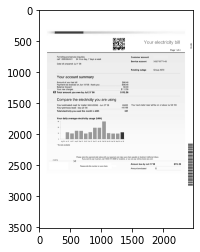

In [47]:
test_img_path = images['qr'][0]
test_img = plt.imread(test_img_path)
plt.imshow(test_img)

# Google API

In [7]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

In [8]:
def detect_text(path):
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    text_annotations = response.text_annotations

    texts = [ta.description for ta in text_annotations]

#     vertices = (['({},{})'.format(vertex.x, vertex.y)
#                  for vertex in text.bounding_poly.vertices])
#     print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return texts

In [42]:
def getTextListByGoogle(image_urls):
    img_texts = []
    durations = []
    
    for url in image_urls:
        start = time.time()
        img_texts.append(detect_text(url))
        end = time.time()
        durations.append(end - start)
        
    return img_texts, durations

### 테스트

In [49]:
image_urls = [
    test_img_path
]

(img_texts, durations) = getTextListByGoogle(image_urls)

In [51]:
durations

[0.90447998046875]

In [50]:
print(img_texts)

[["Your electricity bill\nPage 1 of 4\nFor billing and service inquiries\ncall 1-800-684-81\nCustomer account\n24 hrs a day, 7 days a week\nService account\n3-027-9771-45\nDate bill prepared: Jul 1 '08\nRotating outage\nGroup A070\nYour account summary\nAmount of your last bill\nPayment we received on Jun 18 '08 - thank you\nBalance forward\n$86.46\n-$86.46\n$0.00\n$112.56\nYour new charges\nS Total amount you owe by Jul 21 '08\n$112.56\nCompare the electricity you are using\nYour estimated read for meter 308-520042 - Jun 27 '08\nYour next meter read will be on or about Jul 29 '08.\n65850\n- 65199\nYour previous read - May 29 '08\nTotal electricity you used this month in kWh\n651\nYour daily average electricity usage (kWh)\n58\n39\n19\nJun '06 Jun '07 Jul '07 Aug '07 Sep '07 Oct '07 Nov '07 Dec '07 Jan '08 Feb '08 Mar '08 Apr '08 May '08 Jun '08\n* No data available\nPlease return the payment stub below with your payment and make your check payable to Southern California Edison.\nIf yo

---
# keras-ocr

In [11]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [12]:
def recognizeImgByKeras(image_urls):
    images = [ keras_ocr.tools.read(url) for url in image_urls]
    prediction_groups = [pipeline.recognize([url]) for url in image_urls]

    fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
    for idx, ax in enumerate(axs):
        keras_ocr.tools.drawAnnotations(image=images[idx], 
                                        predictions=prediction_groups[idx][0], ax=ax)

In [52]:
def getTextListByKeras(image_urls):
    images = [ keras_ocr.tools.read(url) for url in image_urls]
    prediction_groups = pipeline.recognize(images)

    img_texts = []
    durations = []
    for group in prediction_groups:
        start = time.time()
        texts = []
        
        for text, box in group:
            texts.append(text)
            
        img_texts.append(texts)
        end = time.time()
        durations.append(end - start)

    return img_texts, durations

### 함수 테스트

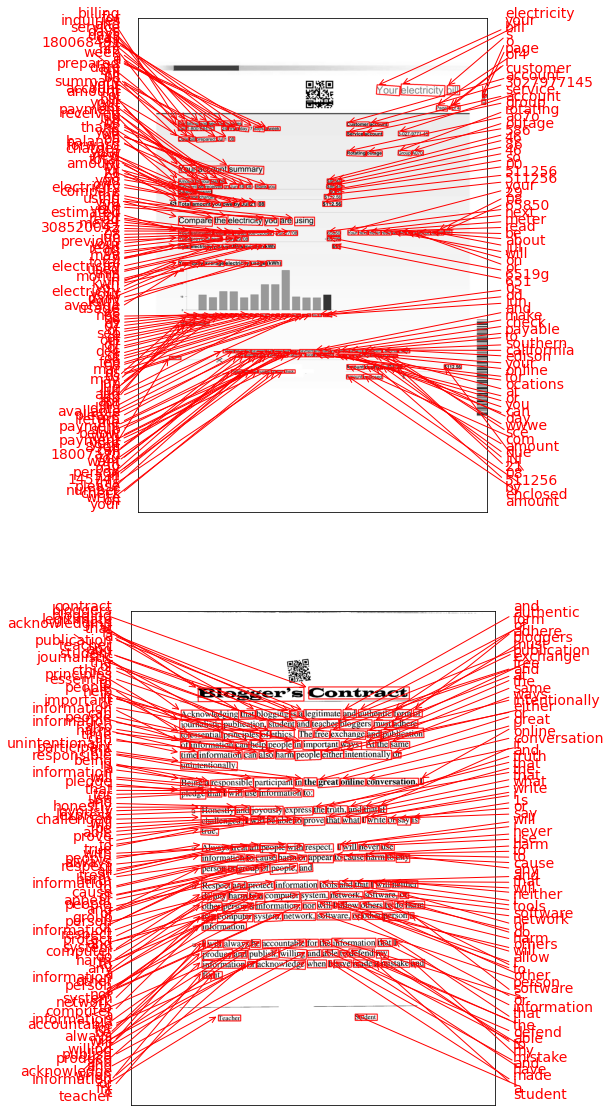

In [14]:
image_urls = [
    test_img_path,
    images['bill'][1]
]

recognizeImgByKeras(image_urls)

In [53]:
image_urls = [
    test_img_path
]

(img_texts, durations) =  getTextListByKeras(image_urls) # [[], []]

In [55]:
durations

[1.621246337890625e-05]

In [54]:
print(img_texts)

[['your', 'electricity', 'bill', 's', 'o', 'page', 'of4', 'i', 'for', 'billing', 'inquiries', 'and', 'service', 'customer', 'account', 'call', '180068481', '24', 'days', 'days', 'hrs', 'week', 'a', 'a', '3027977145', 'service', 'account', 'date', 'bill', 'prepared', 'jul', '08', 'rotating', 'group', 'ao7o', 'outage', 'your', 'account', 'summary', 'amount', 'of', 'bill', '586', '46', 'your', 'last', 'payment', 'received', 'jun', '18', '08', 'thank', '86', '46', 'we', 'you', 'on', 'balance', 'forward', 'so', '00', '511256', 'your', 'charges', 'new', 'total', '511256', 'amount', 'by', 'jul', '21', '08', 'you', 'owe', 'compare', 'electricity', 'the', 'using', 'you', 'are', 'your', 'estimated', 'for', 'your', '29', '08', 'read', 'meter', '308520042', '27', '08', '65850', 'next', 'meter', 'read', 'will', 'be', 'about', 'jul', 'jun', 'on', 'or', 'your', 'previous', 'read', '08', '6519g', 'may', '29', 'total', 'electricity', 'used', 'this', 'month', 'in', 'kwh', '651', 'you', 'your', 'daily', 

---
# Tesseract OCR

In [17]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
#             print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    print('Crop Done!')
    return cropped_image_path_list


def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    img_texts = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        
        text = recognized_data['text'].replace('\x0c', '').replace('\n', '')
        img_texts.append(text)
    print('Recognize Done!')
        
    return img_texts

### 테스트

In [56]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_work'

def getTextListByTesseract(image_urls):
    img_texts = []
    durations = []
    
    for url in image_urls:
        start = time.time()
        cropped_image_path_list = crop_word_regions(url, work_dir)
        img_texts.append(recognize_images(cropped_image_path_list))
        end = time.time()
        durations.append(end - start)
    
    return img_texts, durations

In [57]:
(img_texts, durations) = getTextListByTesseract([test_img_path])

Crop Done!
Recognize Done!


In [58]:
durations

[52.050527811050415]

In [59]:
print(img_texts)

[['Your', 'electricity', 'DI', '', 'Cerrar reece SSS', 'ee', 'i', 'SSSR ae Sea Ripe rUR RE een rurAsLeree', 'Ld... cL Lc Llc cc. cc. ccc. cc cL LL“ LL LL UL.', '', 'a', '————', 'ee eae a a eee', 're etkset$segeitr»e#e#fe6 zi —zeirtfeltie#F#fftfei&eeegegtrbe ii 3', '', '', '——', '_———_c— oe ee ee cee ee ee eS SS eS SS', 'rll rll rll rlUrlU lll he | 6', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'a', 'ATL 3 f', 'co', '1', 'Page', '4', 'of 4', '4', 'For', 'DINING', 'and', 'service', 'inquiries', 'Customer', 'account', 'Call', '1-800-684-87', 'D4', 'nrs a', 'day,', 'f', 'days', 'a', 'week', 'Service', 'account', '3-02 /7-97/1-45', 'Late', 'OI', 'prepared:', 'Jul', '4', '‘08', 'Rotating', 'outage', 'Group', 'A0O/70', 'Your', 'account', 'SUMMAry', 'Amount', 'of', 'YOUr', 'last', 'OI', '$86.46', 'Payment', 'We', 'received', 'On', 'Jun', '18', '‘08', 'a', 'thank', 'YOu', '-$86.46', 'Balance', 'forwara', '$0.00', 'Your', 'new', 'charges', '$112.5

---

# 서비스의 목적과 내용

### "스캔 문서/이미지 텍스트 추출 서비스"

- 목적 : 스캔한 문서 또는 이미지에서 텍스트를 자동 추출하여 텍스트 전자화를 제공하는 서비스
- 내용
    1. 대상 종류는 다양합니다.
        - 프린트 문서, 손글씨 문서, 명함, 바코드 등 사용자가 스캔한 문서/이미지 모두 해당합니다.
    2. 대상 퀄리티는 보장할 수 없습니다.
        - 어떤 퀄리티에서도 텍스트 추출에 대해서 일정 이상 성능을 보여줘야 합니다.
    3. 대상의 "텍스트 전자화"가 주 목적이므로 "문단, 띄어쓰기"와 같은 문장구성은 서비스 이용 후 사용자가 별도 점검해야 합니다. 

---

# Google OCR API, keras-ocr, Tesseract OCR 분석
- 20개 테스트 이미지에 대해 각 함수를 호출하여 분석 결과를 저장합니다.


### To-do list

4. 각 분석 결과 나란히~ 정리해서 보여주기
5. (결과 시각화 - 비교 잘 되도록) 왼쪽 이미지 - 각 테스트 결과 데이터 (표로 보여주면 좋을 것 같은데...)
6. 결과 분석 & 결과 비교

### Google OCR API 이미지 분석

In [65]:
google_result = {}

for keyword in images:
    print('analyzing this >>> ', images[keyword])
    (img_texts, durations) = getTextListByGoogle(images[keyword])
    google_result[keyword] = img_texts
    google_result[keyword + '_performance'] = durations
    
print('Done!')

analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/barcode/barcode2.png', '/aiffel/aiffel/ocr_python/project/barcode/Barcode_3.jpg']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/qr/QR_Code_097.png', '/aiffel/aiffel/ocr_python/project/qr/QR_Code_066.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/business_cards/doc10002.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10001.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10003.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/checkmark/Page_07.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_03.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_06.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_01.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_1.jpg', '/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_5.jpg', '/aiffel/aiffel/ocr_python/project/mobile_photo/IMG_0122.jpg', '/aiffel/aiffel/ocr_python/project/mobile_

### Keras OCR API 이미지 분석

In [60]:
keras_result = {}

for keyword in images:
    start = time.time()
    
    print('analyzing this >>> ', images[keyword])
    (img_texts, durations) = getTextListByKeras(images[keyword])
    keras_result[keyword] = img_texts
    keras_result[keyword + '_performance'] = durations
    
print('Done!')

analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/barcode/barcode2.png', '/aiffel/aiffel/ocr_python/project/barcode/Barcode_3.jpg']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/qr/QR_Code_097.png', '/aiffel/aiffel/ocr_python/project/qr/QR_Code_066.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/business_cards/doc10002.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10001.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10003.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/checkmark/Page_07.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_03.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_06.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_01.png']
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_1.jpg', '/aiffel/aiffel/ocr_python/project/mobile_photo/MobPhoto_5.jpg', '/aiffel/aiffel/ocr_python/project/mobile_photo/IMG_0122.jpg', '/aiffel/aiffel/ocr_python/project/mobile_

### Tesseract OCR API 이미지 분석

In [61]:
tesseract_result = {}

for keyword in images:
    print('analyzing this >>> ', images[keyword])
    (img_texts, durations) = getTextListByTesseract(images[keyword])
    tesseract_result[keyword] = img_texts
    tesseract_result[keyword + '_performance'] = durations
    
print('Done!')

analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/barcode/barcode2.png', '/aiffel/aiffel/ocr_python/project/barcode/Barcode_3.jpg']
Crop Done!
Recognize Done!
Crop Done!
Recognize Done!
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/qr/QR_Code_097.png', '/aiffel/aiffel/ocr_python/project/qr/QR_Code_066.png']
Crop Done!
Recognize Done!
Crop Done!
Recognize Done!
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/business_cards/doc10002.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10001.png', '/aiffel/aiffel/ocr_python/project/business_cards/doc10003.png']
Crop Done!
Recognize Done!
Crop Done!
Recognize Done!
Crop Done!
Recognize Done!
analyzing this >>>  ['/aiffel/aiffel/ocr_python/project/checkmark/Page_07.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_03.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_06.png', '/aiffel/aiffel/ocr_python/project/checkmark/Page_01.png']
Crop Done!
Recognize Done!
Crop Done!
Recognize Done!
Crop Done!
Re

---

# 분석결과 1) 성능 비교

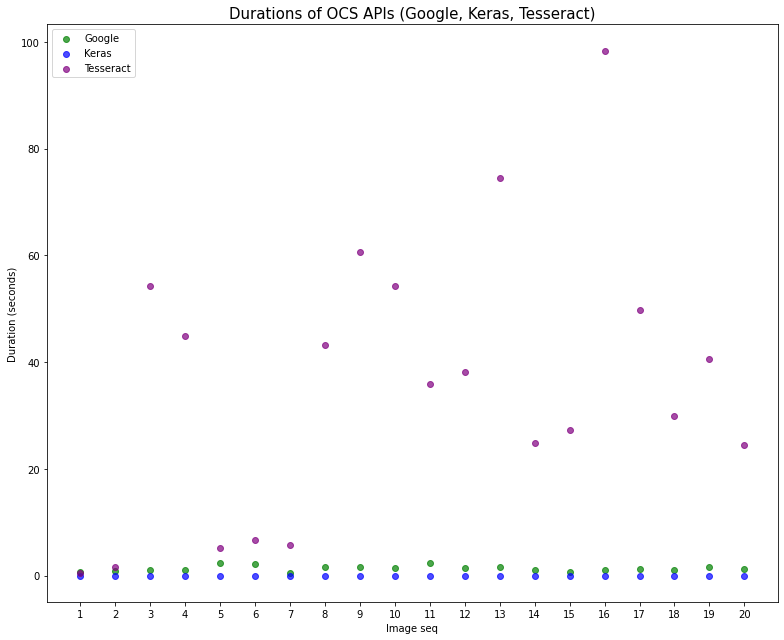

In [141]:
plt.rcParams["figure.autolayout"] = True
ax1 = plt.subplot()
ax1.set_xticks(x_labels)
ax1.set_xticklabels(x_labels)

plt.scatter(
    x=x_labels,
    y=gle_pfm,
    color="green",
    alpha=0.7,
    label="Google"
)
plt.scatter(
    x=x_labels,
    y=krs_pfm,
    color="blue",
    alpha=0.7,
    label="Keras"
)
plt.scatter(
    x=x_labels,
    y=tsr_pfm,
    color="purple",
    alpha=0.7,
    label="Tesseract"
)
plt.title('Durations of OCS APIs (Google, Keras, Tesseract)', fontsize=15)
plt.xlabel("Image seq")
plt.ylabel("Duration (seconds)")
plt.legend(loc='upper left')
plt.show()

In [119]:
x_labels = []
gle_pfm = []
krs_pfm = []
tsr_pfm = []
i = 0

for keyword in keywords:
    for gle, krs, tsr in zip(google_result[keyword + '_performance'], keras_result[keyword + '_performance'], tesseract_result[keyword + '_performance']):
        i += 1
        x_labels.append(i)
        gle_pfm.append(gle)
        krs_pfm.append(krs)
        tsr_pfm.append(tsr)

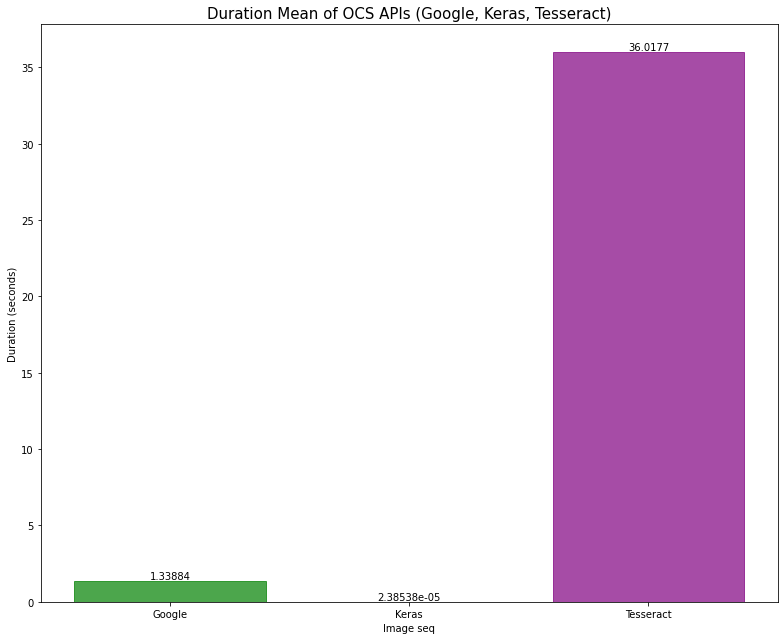

In [158]:
gle_mean = np.array(gle_pfm).mean()
krs_mean = np.array(krs_pfm).mean()
tsr_mean = np.array(tsr_pfm).mean()

fig, ax = plt.subplots()
barlist = plt.bar(['Google', 'Keras', 'Tesseract'], [gle_mean, krs_mean, tsr_mean], alpha=0.7)
barlist[0].set_color('green')
barlist[1].set_color('blue')
barlist[2].set_color('purple')
plt.title('Duration Mean of OCS APIs (Google, Keras, Tesseract)', fontsize=15)
plt.xlabel("Image seq")
plt.ylabel("Duration (seconds)")
ax.bar_label(ax.containers[0])
plt.show()

### API 별 속도 성능은 Keras -> Google -> Tesseract 순으로 빠릅니다. 
- **텍스트 추출 품질**을 우선으로 두는 것이 옳지만, 품질 대비 속도 성능도 중요하기 때문에 속도 비교를 추가했습니다.
- `Tesseract` 속도 성능이 너무 느리기 때문에, 품질 대비 속도가 월등히 안좋다면 Tesseract API는 OCR 서비스로 적합하지 않다 판단됩니다.
- `Google`과 `Keras`의 평균 속도가 2초 이내로 모두 처리되므로, (품질을 보고) 이 두 API 중에서 텍스트 추출 품질 기준으로 결정하는 것이 좋을 것 같습니다.

---

# 분석 결과 2) 텍스트추출 비교



----------------------------------------------------------------------------------------------------

[barcode]




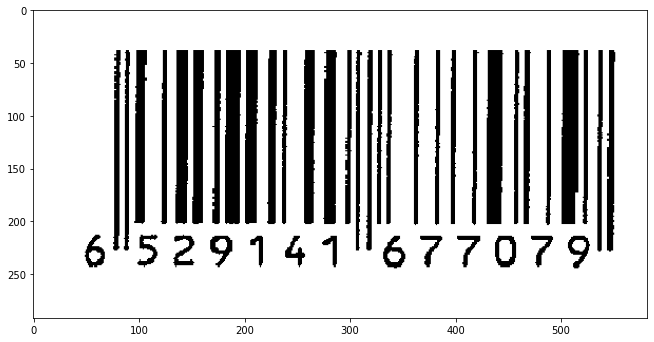


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
6529141"677079

Keras API >>>>> 
bitizz

Tesseract API >>>>> 
229141"67 7079




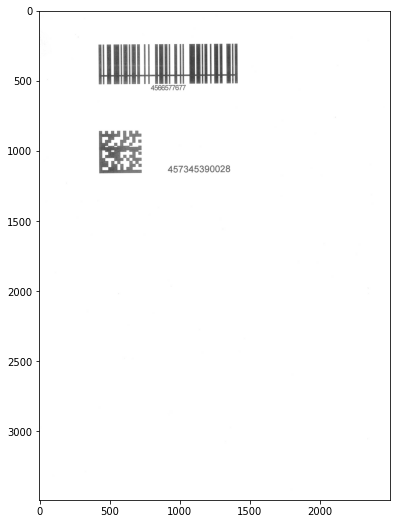


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
4566577677 457345390028

Keras API >>>>> 
4566571677 s 457345390028

Tesseract API >>>>> 
A5665//6//  457345390028


----------------------------------------------------------------------------------------------------

[qr]




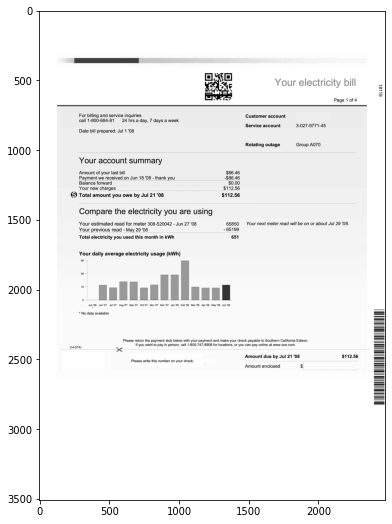


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
Your electricity bill Page 1 of 4 For billing and service inquiries call 1-800-684-81 Customer account 24 hrs a day, 7 days a week Service account 3-027-9771-45 Date bill prepared: Jul 1 '08 Rotating outage Group A070 Your account summary Amount of your last bill Payment we received on Jun 18 '08 - thank you Balance forward $86.46 -$86.46 $0.00 $112.56 Your new charges S Total amount you owe by Jul 21 '08 $112.56 Compare the electricity you are using Your estimated read for meter 308-520042 - Jun 27 '08 Your next meter read will be on or about Jul 29 '08. 65850 - 65199 Your previous read - May 29 '08 Total electricity you used this month in kWh 651 Your daily average electricity usage (kWh) 58 39 19 Jun '06 Jun '07 Jul '07 Aug '07 Sep '07 Oct '07 Nov '07 Dec '07 Jan '08 Feb '08 Mar '08 Apr '08 May '08 Jun '08 * No data available Please return the payment stub below with your payment and make your check payable to Southern California 

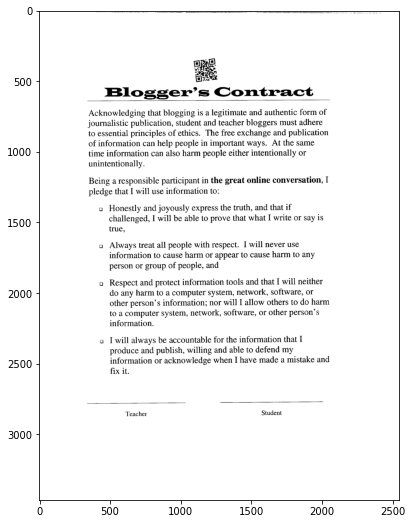


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
Blogger's Contract Acknowledging that blogging is a legitimate and authentic form of journalistic publication, student and teacher bloggers must adhere to essential principles of ethics. The free exchange and publication of information can help people in important ways. At the same time information can also harm people either intentionally or unintentionally. Being a responsible participant in the great online conversation, I pledge that I will use information to: a Honestly and joyously express the truth, and that if challenged, I will be able to prove that what I write or say is true, o Always treat all people with respect. I will never use information to cause harm or appear to cause harm to any person or group of people, and Respect and protect information tools and that I will neither do any harm to a computer system, network, software, or other person's information; nor will I allow others to do harm to a computer system, netwo

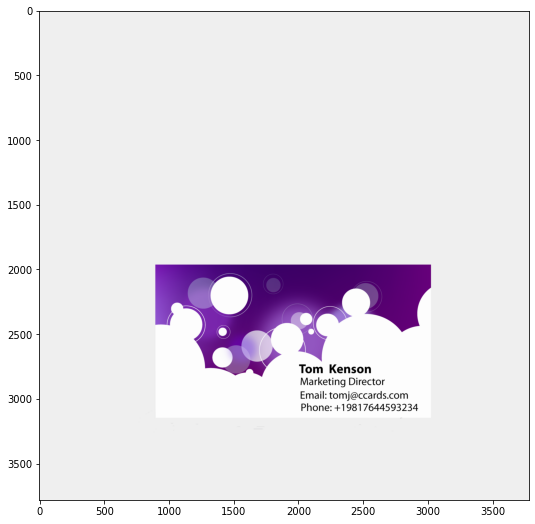


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
Tom Kenson Marketing Director Email: tomj@ccards.com Phone: +19817644593234

Keras API >>>>> 
tom kenson director marketing tomjaccardscom email phones 718176445636a

Tesseract API >>>>> 
| 59. ) . Tom Kenson Marketing 1 irector Email: tomj@ccards.com Phone: +1981 /644593734




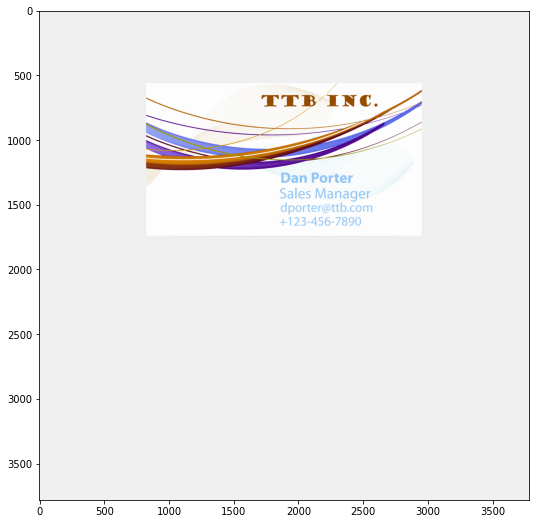


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
TTB INC. Dan Porter Sales Manager dporter@ttb.com +123-456-7890

Keras API >>>>> 
tib inc porter dan sales manager dporterattbocom 1234567890 t

Tesseract API >>>>> 
WesU Ff INC.  em ————  Porter Sales Manager dporter@ttb.com +1)3-456-/890 ~~ Sage 7




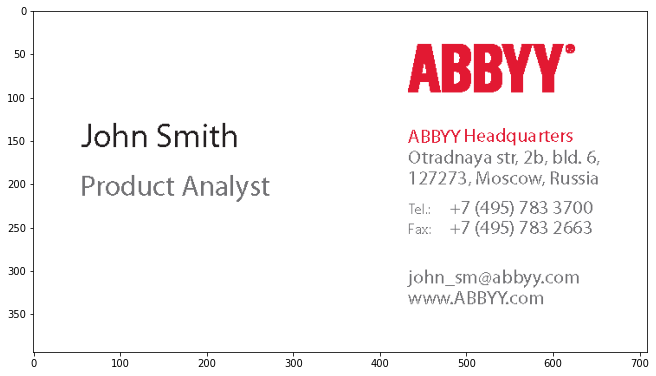


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
ABBYY John Smith ABBYY Headqua rters Otradnaya str, 2b, bld. 6, 127273, MosCow, Russia Product Analyst Tel.: +7 (495) 783 3700 Fax: +7 (495) 783 2663 john_sm@abbyy.com www.ABBYY.com

Keras API >>>>> 
abbyy smith john headqua abbyy rters otradnaya bld 2b 6 str 1272735 moscows russia product analyst t7 1495 785 3700 tel t7 1495 785 2663 faxi john smaabbyycom wwwabbycom

Tesseract API >>>>> 
ABBYY Jonn Smith ABBY Headquarters Otradnaya SU dD, Hic. 6, 17/27/3, ViIOSCOW, HuUSSIa le] 4 / (495) 83 4/00 + ay 4 / (495) 83 46604 Product Analyst jonn_sm@abbyy.com WihhhtABRBY ¥i.com


----------------------------------------------------------------------------------------------------

[checkmark]




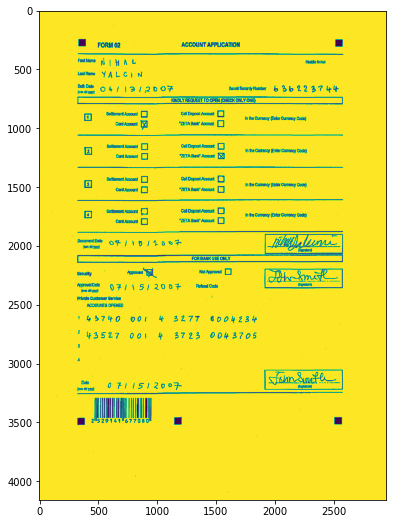


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
FORM 02 ACCOUNT APPLICATION www First Name NI HAL Middle Inital Last Name YA LC) N Birth Dale O 4 / 1312007 Social Security Number 636223744 (mm dd yyy) KINDLY REQUEST TO OPEN (CHECK ONLY ONE) Settlement Account Call Deposit Account In the Currency (Enter Currency Code) Card Account "ZETA Bank" Account Settlement Account Call Deposit Account 2. In the Currency (Enter Currency Code) Card Account "ZETA Bank" Account Setlement Account Call Deposit Account 3. In the Currency (Enter Currency Code) Card Account "ZETA Bank" Account Settlement Account Call Deposit Account 4 In the Currency (Enter Curency Code) Card Account "ZETA Bank" Account Document Date 07 115 / I 007 (mm dd yyy) (Signaturo) FOR BANK USE ONLY Security Approved Not Approved U Approval Date 07/151 2007 Refusal Code (Signature) (mm dd yyyy) Private Customer Service ACCOUNTS OPENED 1 4 3740 4 3277 800423 4 2 43527 0 01 4 3723 0043705 3 4 Date o 7 1 1512007 (Signature) (mm dd 

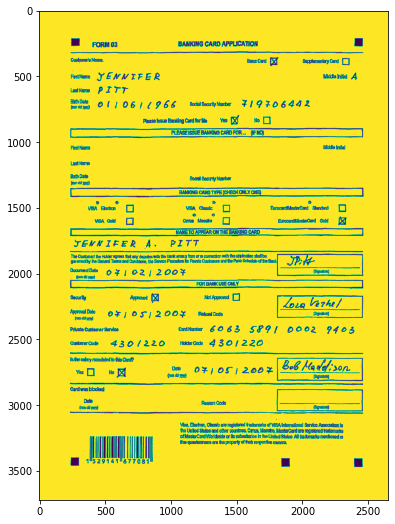


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
FORM 03 BANKING CARD APPLICATION Customer's Name. Basıc Card X Supplementary Card O First Name YENNIFER Middla Initial 4 Last Name P ITT Birth Date (mi dd yyy) O11 061 1 966 71970644 2 Social Security Number Please Issue Banking Card for Me Yes X No U PLEASE ISSUE BANKING CARD FOR. (F NO) First Name Middle Initial Last Name Birth Date Socral Secunty Number (mm dd ywy) BANKING CARD TYPE (CHECK ONLY ONE) VISA Electron VISA Classic EurocardMasterCard Standard 区 VISA Gold Cirus MaestrO EurocardMasterCard Gold NAME TO APPEAR ON THE BANKING CARD JENN IFER A. PITT The Customer/ the Holder agrees that any disputes with the Bank ansng from or m connection with this application shall be governed by the General Terms and Condrions, the Service Procedure for Prvate Customers and the Price Schedule of the Bank Document Date O¥ 1 02 1 2007 (Sgnature) (mm đd yyyy) FOR BANK USE ONLY Security Approved X Not Approved Loea Vezhel Approval Date (ram dd 

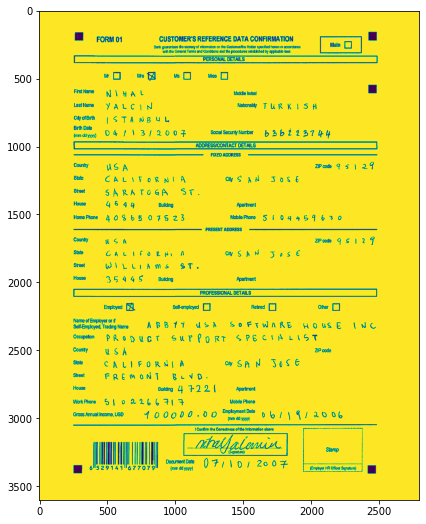


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
FORM 01 CUSTOMER'S REFERENCE DATA CONFIRMATION Main Bank guarantees the secrecy of information on the Customer/the Holder specified herein in accordance with the General Terms and Conditions and the procedures established by appicable laws PERSONAL DETAILS Mr Mrs Ms Mıss First Name Ni HAL Middle Initial YALCIN Nationality T u RKIS H Last Name City of Birth Birth Date (mm dd yyy) U 4 / 3/2 007 Social Security Number b 3 62 237 44 ADDRESS/CONTACT DETAILS FIXED ADDRESS Country uS A ZIP code 9 Ś 29 CALIFORNIA City Ŝ À N State Jos E 5 ARA TOGA Street ST. House 4 6 4 4 Building Apartment Home Phone 4 0 8 65 0 7523 Mobile Phone 5 í 0 4 4 5 9 6 3 0 PRESENT ADDRESS Country USA ZIP code 9 5 1 2 9 City S A N J oS E State A Jos E Street WILLIAMS ST. House 354 4 5 Building Apartment PROFESSIONAL DETAILS Empioyed A Self-employed O Retred Other Name of Employer or if Self-Employed, Tradıng Name A BB Y Y US A s o F ī W A RE I NC Occupation PRODUDCT 

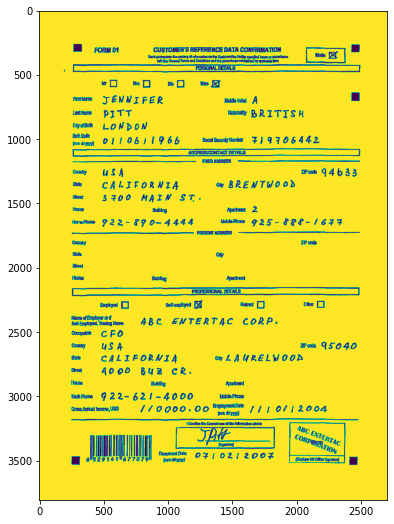


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
FORM 01 CUSTOMER'S REFERENCE DATA CONFIRMATION Main A Bark gutrtc the sectucy of nfonmeton.cntro Cbre Holer pfed harannaccordence h the Ganerai Tarm and Condftons end the procedures estebched by sppicabb lars PERSONAL DETAILS Mrs O Ms O Miss X Frst Nerne JENNIFER Mddle Intal A PITT Nabonality BRITISH Last Name City ofButh LONDON Brth Date 0110611 966 Socal Securily Number 719706442 (mm dd yyy) ADDRESS/CONTACT DETAILS FIXED ADDRESS uSA CALIFORNIA County ZIP code 9 4 6 33 City BRENTWOOD State 3 700 MAIN ST. Street House Bulding Apartment 2 Home Phane 72 2 - 89 0- 4 444 Mabila Phone 9 2 5 - 888- / 677 PRESENT ADDRESS www Contry ZIP code State City Street House Buldng Apartment PROFESSIONAL DETAILS Employed O Self-employed X Rebred Oher Name of Employar or if SelFEmployed, Tradlng Narne ABC ENTERTAC CORP. Occupation CFO ZP code 95040 uS A CALIFORNIA BUZ CR. Counbry Cty L A URELWOOD State Sreet A000 House Bulding Apartment Wionk Phame 9 2

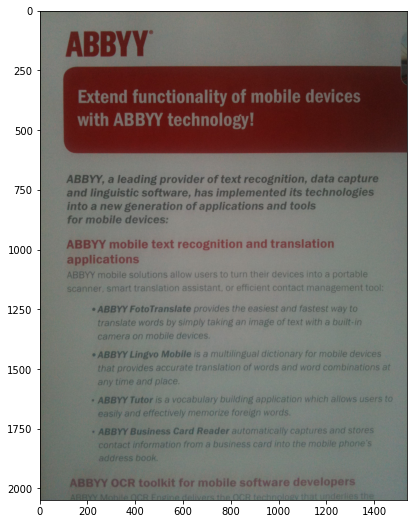


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
ABBYY Extend functionality of mobile devices with ABBYY technology! ABBYY, a leading provider of text recognition, data capture and linguistic software, has implemented its technologies into a new generation of applications and tools for mobile devices: ABBYY mobile text recognition and translation applications ABBYY mobile solutions allow users to turn their devices into a portable scanner, smart translation assistant, or efficient contact management tool: ABBYY FotoTranslate provides the easiest and fastest way to translate words by simply taking an image of text with a built-in camera on mobile devices. ABBYY Lingvo Mobile is a multilingual dictionary for mobile devices that provides accurate translation of words and word combinations at any time and place. ABBYY Tutor is a vocabulary building application which allows users to easily and effectively memorize foreign words. ABBYY Business Card Reader automatically captures and stor

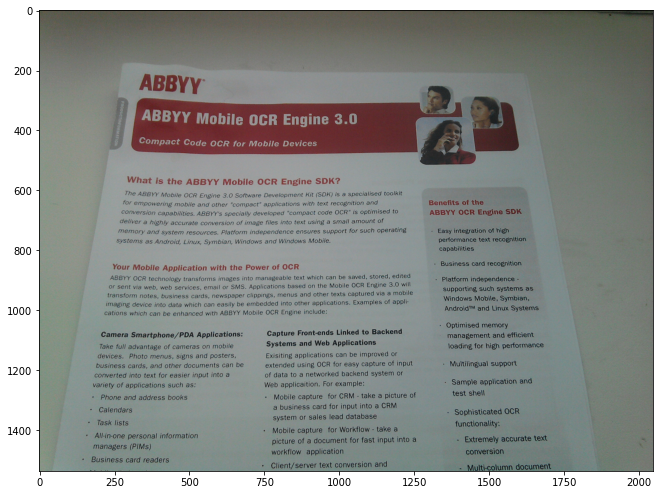


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
ABBYY ABBYY Mobile OCR Engine 3.0 Compact Code OCR for Mobile Devices What is the ABBYY Mobile OCR Engine SDK? The ABBYY Mobile OCR Engine 3.0 Software Development Kit (SDK) is a specialised toolkit for empowering mobile and other "compact" applications with text recognition and conversion capabilities. ABBYY's specially developed "compact code OCR" is optimised to deliver a highly accurate conversion of image files into text using a small amount of Benefits of the ABBYY OCR Engine SDK memory and system resources. Platform independence ensures support for such operating systems as Android, Linux, Symbian, Windows and Windows Mobile. Easy integration of high performance text recognition capabilities Business card recognition Your Mobile Application with the Power of OCR ABBYY OCR technology transforms images into manageable text which can be saved, stored, edited or sent via web, web services, email or SMS. Applications based on the M

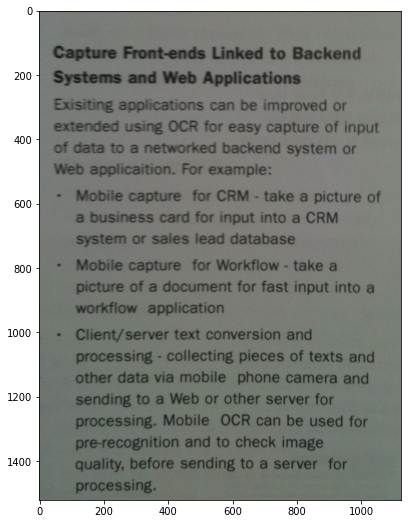


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
Capture Front-ends Linked to Backend Systems and Web Applications Exisiting applications can be improved or extended using OCR for easy capture of input of data to a networked backend system or Web applicaition. For example: Mobile capture for CRM - take a picture of a business card for input into a CRM system or sales lead database Mobile capture for Workflow - take a picture of a document for fast input into a workflow application Client/server text conversion and processing - collecting pieces of texts and other data via mobile phone camera and sending to a Web or other server for processing. Mobile OCR can be used for pre-recognition and to check image quality, before sending to a server for processing.

Keras API >>>>> 
capture frontends linked backend to systems and web applications exisiting applications be improved can or ocr extended using for of input capture easy of data networked backend to system a or web applicaition fo

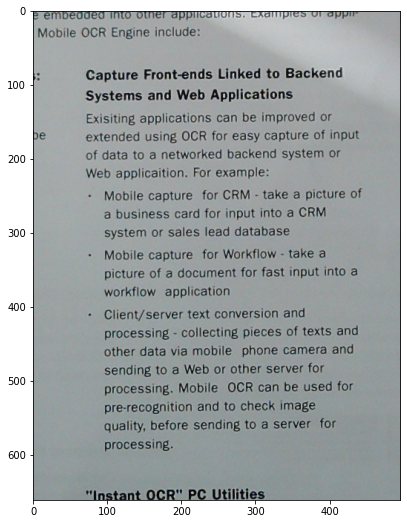


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
e embedded into other applications. Examples of appl- Mobile OCR Engine include: Capture Front-ends Linked to Backend Systems and Web Applications Exisiting applications can be improved or extended using OCR for easy capture of input of data to a networked backend system or Web applicaition. For example: be Mobile capture for CRM take a picture of a business card for input into a CRM system or sales lead database Mobile capture for Workflow take a picture of a document for fast input into a workflow application Client/server text conversion and processing - collecting pieces of texts and other data via mobile phone camera and sending to a Web or other server for processing. Mobile OCR can be used for pre-recognition and to check image quality, before sending to a server for processing. "Instant OCR" PÇ Utilities

Keras API >>>>> 
embedded into other appications exampies or appun e includes mobile ocr engine backend frontends linked t

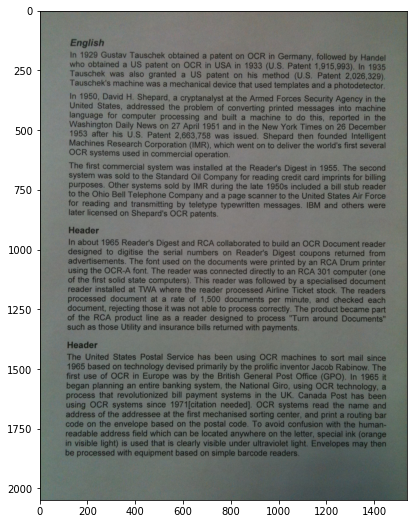


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
English In 1929 Gustav Tauschek obtained a patent on OCR in Germany, followed by Handel who obtained a US patent on OCR in USA in 1933 (U.S. Patent 1,915,993). In 1935 Tauschek was also granted a US patent on his method (U.S. Patent 2,026,329). Tauschek's machine was a mechanical device that used templates and a photodetector. In 1950, David H. Shepard, a cryptanalyst at the Armed Forces Security Agency in the United States, addressed the problem of converting printed messages into machine language for computer processing and built a machine to do this, reported in the Washington Daily News on 27 April 1951 and in the New York Times on 26 December 1953 after his U.S. Patent 2,663,758 was issued. Shepard then founded Intelligent Machines Research Corporation (IMR), which went on to deliver the world's first several OCR systems used in commercial operation. The first commercial system was installed at the Reader's Digest in 1955. The s

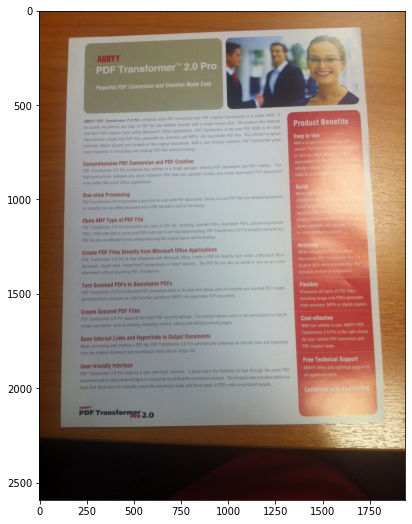


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
ABBYY PDF Transformer™ 2.0 Pro Powerful PDF Conversion and Creation Made Easy ABBYY PDF Transformer 2.0 Pro combines both PDF conversion and PDF creation functionality in a single utility. It accurately transforms any type of PDF file into editable formats with a single mouse click. The product also features one-click PDF creation from within Microsoft Office applications. PDF Transformer is the only PDF utility in its class that converts image-only PDF files, generated by scanners and MFPS, into searchable PDF files. This efficient program precisely retains layouts and formats of the original documents. With a user-friendly interface, PDF Transformer gives users flexibility in converting and creating PDF files without training. Product Benefits Easy to Use With a single mouse-cick yu convert POF les to eta or turn an ofice decu Comprehensive PDF Conversion and PDF Creation searchable POFe PDF Transformer 2.0 Pro combines two utiliti

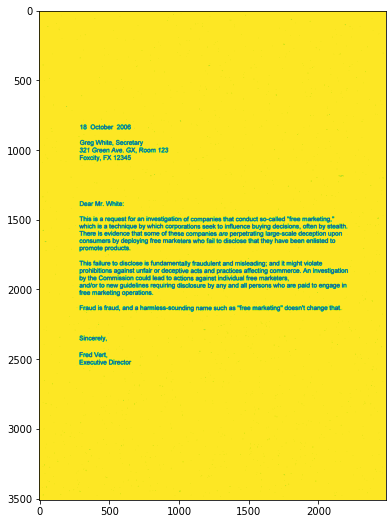


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
18 October 2006 Greg White, Secretary 321 Green Ave. GX, Room 123 Foxcity, FX 12345 Dear Mr. White: This is a request for an investigation of companies that conduct so-called "free marketing," which is a technique by which corporations seek to influence buying decisions, often by stealth. There is evidence that some of these companies are perpetrating large-scale deception upon consumers by deploying free marketers who fail to disclose that they have been enlisted to promote products. This failure to disclose is fundamentally fraudulent and misleading; and it might violate prohibitions against unfair or deceptive acts and practices affecting commerce. An investigation by the Commission could lead to actions against individual free marketers, and/or to new guidelines requiring disclosure by any and all persons who are paid to engage in free marketing operations. Fraud is fraud, and a harmless-sounding name such as "free marketing" doe

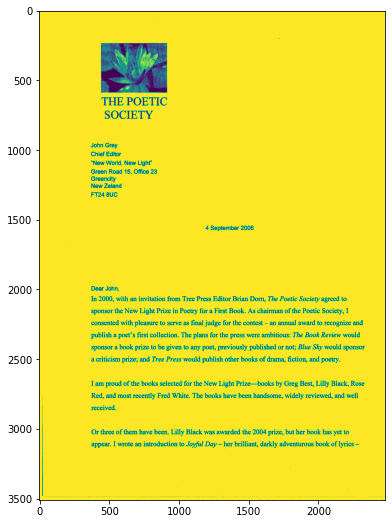


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
THE POETIC SOCIETY John Grey Chief Editor "New World, New Light" Green Road 15, Office 23 Greencity New Zeland FT24 8UC 4 September 2006 Dear John, In 2000, with an invitation from Tree Press Editor Brian Dorn, The Poetic Society agreed to sponsor the New Light Prize in Poetry for a First Book. As chairman of the Poetic Society, I consented with pleasure to serve as final judge for the contest – an annual award to recognize and publish a poet's first collection. The plans for the press were ambitious: The Book Review would sponsor a book prize to be given to any poet, previously published or not; Blue Sky would sponsor a criticism prize; and Tree Press would publish other books of drama, fiction, and poetry. I am proud of the books selected for the New Light Prize-books by Greg Best, Lilly Black, Rose Red, and most recently Fred White. The books have been handsome, widely reviewed, and well received. Or three of them have been. Lilly

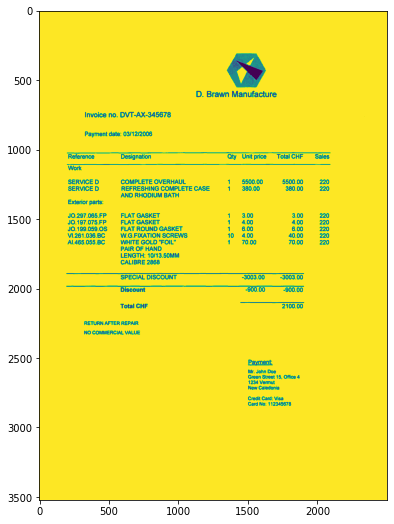


위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.

Google API >>>>> 
D. Brawn Manufacture Invoice no. DVT-AX-345678 Payment date: 03/12/2006 Reference Designation Qty Unit price Total CHF Sales Work 5500.00 5500.00 SERVICE D SERVICE D COMPLETE OVERHAUL REFRESHING COMPLETE CASE AND RHODIUM BATH 1 220 1 380.00 380.00 220 Exterior parts: 3.00 JO.297.065.FP JO.197.075.FP JO.199.059.0S VI.261.036.BC Al.465.055.BC FLAT GASKET FLAT GASKET 3.00 4.00 6.00 40.00 70.00 1 220 1 4.00 220 FLAT ROUND GASKET W.G.FIXATION SCREWS 6.00 10 4.00 70.00 220 220 WHITE GOLD "FOIL" PAIR OF HAND LENGTH: 10/13.50MM 11 220 CALIBRE 2868 SPECIAL DISCOUNT -3003.00 -3003.00 Discount -900.00 -900.00 Total CHF 2100.00 RETURN AFTER REPAIR NO COMMERCIAL VALUE Рayment: Mr. John Doe Green Street 15, Office 4 1234 Vermut New Caledonia Credit Card: Visa Card No: 112345678

Keras API >>>>> 
d manufacture brawn dvtax345676 invoice no payment dater 0317 212006 reference designation unit total sales qty price chf work service complete overhaul 5

In [104]:
for keyword in keywords:
    print('\n\n----------------------------------------------------------------------------------------------------\n')
    print(f'[{keyword}]')
    for img, gle, krs, tsr in zip(images[keyword], google_result[keyword], keras_result[keyword], tesseract_result[keyword]):
        print('\n')
        plt.rcParams["figure.figsize"] = (11, 9)
        plt_img = plt.imread(img)
        plt.imshow(plt_img)
        plt.show()
        print('\n위 이미지에 대한 각 OCR 분석 결과는 다음과 같습니다.\n')
        print('Google API >>>>> ')
        print(' '.join(gle[1:]))
        print('\nKeras API >>>>> ')
        print(' '.join(krs))
        print('\nTesseract API >>>>> ')
        print(' '.join(tsr))

### Google API 분석 결과가 가장 월등히 좋습니다.

- 숫자, 문자, 손글씨, 특수문자 추출 결과를 보았을 때, Google의 결과가 더 뚜렷히 좋았습니다.
- 또한 Google API는 결과 첫번째 인덱스에서, 문장 구성 결과(띄어쓰기 + 줄바꿈 포함)를 함께 반환하기 때문에 더 좋은 서비스를 제공할 수 있을거라 판단됩니다.

---

# 비교 분석 정리/결과

```
"API 별 속도 성능은 Keras -> Google -> Tesseract 순으로 빠릅니다."
    - 텍스트 추출 품질을 우선으로 두는 것이 옳지만, 품질 대비 속도 성능도 중요하기 때문에 속도 비교를 추가했습니다.
    - Tesseract 속도 성능이 너무 느리기 때문에, 품질 대비 속도가 월등히 안좋다면 Tesseract API는 OCR 서비스로 적합하지 않다고 생각합니다.
    - Google과 Keras의 평균 속도가 2초 이내로 모두 처리되므로, (품질을 보고) 이 두 API 중에서 텍스트 추출 품질 기준으로 결정하는 것이 좋을 것 같습니다.
    
"Google API 분석 결과가 가장 월등히 좋습니다."
    - 숫자, 문자, 손글씨, 특수문자 추출 결과를 보았을 때, Google의 결과가 더 뚜렷히 좋았습니다.
    - 또한 Google API는 결과 첫번째 인덱스에서, 문장 구성 결과(띄어쓰기 + 줄바꿈 포함)를 함께 반환하기 때문에 더 좋은 서비스를 제공할 수 있을거라 생각합니다.
```

위와 같이 분석을 토대로 

**`Google API`**를 서비스에 적용하는 것이 좋다고 판단했습니다.

---

# 회고

### 프로젝트 수행 및 개선점

1. 20개씩 API 이미지 분석에 용이하도록 함수를 선언하도록 코드를 작성했습니다.
2. API 선정 기준에 API 속도 성능 비교를 넣고 시각화하여 비교했습니다.

### 느낀점

- 직접 가상 서비스/기능을 설정하고 이에 따른 분석을 진행하는 과정이 즐거웠습니다. 
- 그리고 Google은 역시 갓구글이구나 생각했습니다.